# An Interactive Tutorial for Multi-Instance Contrastive Learning (MICLe)

Labelled image datasets are often scarce when looking at specialised fields such as medical imaging. This limiting factor promotes the use of pretraining on a larger unrelated dataset where the model is first trained, following which the model is finetuned on the dataset of interest.

However, with recent progress in self-supervision methods, there is now a second approach to pretraining. Since self-supervision does not require the image dataset to be labelled, it is lucrative to use the unlabelled task specific datasets to get more accurate representations. In cases where the dataset contains multiple images of the same 'category' it is beneficial to use **the Multi-Instance Contrastive Learning (MICLe) Model**.

As outlined in the 2021 paper ["Big Self-Supervised Models Advance Medical Image Classification”](https://arxiv.org/pdf/2101.05224.pdf) by _Azizi et al._ [1], MICLe is used to pretrain on image datasets where there are multiple images of the same 'object' or 'category' (eg: images of the same car from different angles or lighting), which allows greater performance after fine-tuning.

This tutorial will be a **novel implementation**, showing how to create the MICLe model and fit it to a dataset upon which fine-tuning can then be performed. The tutorial will be utilising TensorFlow and Keras.

## 1. Explaining the Multi-Instance Contrastive Learning (MICLe) Model

MICLe applies contrastive learning, wherein an embedding space is learnt such that similar samples stay as close together while contrasting samples stay as far as possible. This technique is applied when there exist multiple images of the same 'object'/'category'. 

Such data is often available in medical imaging datasets. For example, dermatology datasets frequently contain images of multiple views of a pathology of a particular patient. Consider $X$, the images of a pathology of Patient-1 and $Y$ the images of a pathology of Patient-2. MICLe works by taking two images from $X$, let these be $x_1$ and $x_2$, and two images from $Y$, let these be $y_1$ and $y_2$. Images taken from the same set are considered positive pairs while images taken from different sets are considered negative pairs. Then, the loss between each positive pair is minimized while the loss between each negative pair is maximised, applying contrastive learning. Analogously, the technique is applied to datasets when there exist more sets such as $X$ and $Y$, such as images from a Patient-3, Patient-4 etc. 

MICLe does not require labelled datasets since it forms positive pairs by taking images from the same 'category'. This allows the algorithm to create stronger representations that are less biased to changes in view, lighting or other extraneous variables.

## 2. The Algorithm

For dataset $X$, a mini-batch of $\{X\}_{k=1}^N$ is taken, where _N_ = batch size. Each $X_i = \{x_1, x_2,..., x_M\}$, called a bag, contains _M_ images from the same category. When a bag has 2 or more instances, a positive pair is formed by randomly picking two images. If only one instance is present the same instance is taken twice. To these two images a random crop augmentation is applied. The augmented images are then encoded and passed through a non-linear multilayer perception, giving two final arguments for each $X_i$. For 1 bag we have 2 representations, so for all _N_ bags we have $2N$ representations. 

With a mini-batch of encoded examples, the contrastive loss between a positive pair _i, j_ is as given below:

$l_{i,j} = - log\frac{\exp(sim(z_i,z_j)/T)}
{\sum_{k=1}^{2N} \mathbb{1}_{k \neq i} \exp(sim(z_i,z_k)/T)}$

where _T_ is the temperature scalar and sim( , ) is the cosine similarity between two vectors. The training dataset is then optimized over all iterations. An algorithm showing the following is shown below:

**Input:** batch size _N_, constant _T_ , augmenter _t(.)_ , encoder network _f(.)_, non-linear projection head _g(.)_

1. **while** _stopping criteria not met_ **do** <br><br>
    * Sample mini-batch of $\{X\}_{k=1}^N$ **for** $k$ &larr; 1 **_to_** $k = N$
    * **do**
        * if $|X_k| >= 2$ **then**
            * Randomly select $x_m$ and $x_n$ \in $X_k$;
            <br><br>
        * **else**
            * $x_m$ = $x_n$ &larr; the only element in $X_k$;
            <br><br>
        * **end**
        $z_{2k-1} = g(f(t(x_m)))$ ;
        $z_{2k} = g(f(t(x_n)))$ ;
        <br><br>
        * **for** $i \in \{1,...,2N\}$ and $j \in \{1,...,2N\}$ **do**
            * $s_{i,j} = \frac {z_i^t z_j}{||z_i|| ||z_j||}$;
            <br><br>
        $l(i,j)$ from $Eq. (1)$; <br><br>
        $L = \frac{1}{2N} \sum_{k=1}^{N} [l(2k-1, 2k) + l(2k, 2k-1)]$ &ndash;&ndash;&ndash;&ndash;&ndash;&ndash;&ndash;&ndash; Eq. (1)

<br>

Let us start the implementation of MICLe. First we need to import all necessary modules and functions. We need to make sure that eager execution is enabled in case the version of tensorflow being used is an older one.

In [1]:
from encodeutil import myencoder
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras import layers
tf.compat.v1.enable_eager_execution()

## 3. Datasets

The datasets that will be used for this tutorial are original datasets. There is an unlabelled dataset for MICLe training and a labelled dataset for supervised finetuning. Before importing the datasets we must set some hyperparameters.

### Hyperparameters

The following hyperparameters have been set for the purpose of this tutorial. Most of them can be changed according to the requirements of the user.

In [2]:
# Dataset hyperparameters
image_size = 180 # image dimension
image_channels = 3 # rbg

# Algorithm hyperparameters
num_epochs = 10
batch_size = 5 # This is N as mentioned in the algorithm. We have 15 total bags, so for N = 5, each epoch will give 3 iterations
width = 128
temperature = 0.1

### Importing the Unlabeled Dataset

The unlabeled dataset is an original dataset of images of random household object and fruits. Each object has been photographed from multiple angles creating multiple images of the same 'object'/'category'. Thus, all images of the same 'category' belong to one bag.

In [3]:
unlabeled_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/unlabeled_images', labels = 'inferred', label_mode = 'int', image_size=(image_size, image_size), 
    batch_size= batch_size, shuffle= True, seed= 1
)

Found 41 files belonging to 15 classes.


We have imported and shuffled the unlabeled dataset. Although it is unlabeled, we have inferred integer labels to be able to assign an arbitrary integer to each image, wherein the integer corresponds to a particular bag. All images from the same bag have the same integer label. This creates an easy way to track the images. So, we have 15 classes or bags.

## 4. Important Functions

### Dataset Manipulation

To utilise our unlabeled dataset we need to arrange it so that for each bag we can create 2 representations, $z_i$ and $z_j$, while for each batch of size _N_ we can create _2N_ representations. This is done by arranging the images according to the bag they belong to. From each bag then 2 random images are extracted into 2 different tensors. These tensors are then batched for use in the model. Each batch has batch size _N_ = _batch_size_.

For each $X_k$, pick $x_i$ and $x_j$ and collect in two tensors  

In [4]:
def arrange_by_bag(data):
    
    '''
    This function takes a dataset, arranges it according to bags and creates two tensors with each tensor having
    on sample from each bag. 

    Input: Dataset (Labeled by bag)
    Output: TensorFlow Data of shape ((tensor, label),(tensor, label)). The required tensors are the 0th index 
    of the nested tuples
    '''
    try:
        data = data.unbatch()
    except:
        pass
    images = np.asarray(list(data.map(lambda x, y: x)))
    labels = np.asarray(list(data.map(lambda x, y: y)))
    
    unique_labels = np.unique(labels)
    num_bags = len(unique_labels)

    one_hot = []
    bags = []

    for i in range(num_bags): # create a list type structure for bags to store images in and one-hot vectors to signify which image belongs to which bag
        one_hot.append([])
        bags.append([])

    for i in range(num_bags): # assign one-hot vectors for each image
        for l, j in enumerate(labels): # enumerate through labels and create one-hot vectors
            if labels[l] == unique_labels[i] :
                one_hot[i].append(1)
            else:
                one_hot[i].append(0)
        for l, k in enumerate(images): # assign image to appropriate bag
            if one_hot[i][l] == 1:
                bags[i].append(images[l])

    

    sample_i = np.zeros((num_bags, image_size, image_size, image_channels)) 
    sample_j = np.zeros((num_bags, image_size, image_size, image_channels))

    for l, bag in enumerate(bags): # sample 2 image from each bag
        random.seed(2)
        random.shuffle(bag)
        try:
            sample_i[l] = bag[0] 
        except:
           continue
        try:
            sample_j[l] = bag[1] # if bag has 2 image
        except:
            sample_j[l] = bag[0] # if bag has 1 image

    sample_i = tf.convert_to_tensor(sample_i) # tensor with a sample from each bag
    sample_j = tf.convert_to_tensor(sample_j) # tensor with a sample from each bag

    finalsample_i = tf.data.Dataset.from_tensor_slices((sample_i, np.array(range(num_bags)))).batch(batch_size) # batch the dataset
    finalsample_j = tf.data.Dataset.from_tensor_slices((sample_j, np.array(range(num_bags)))).batch(batch_size)

    train_datatset = tf.data.Dataset.zip((finalsample_i, finalsample_j)) # zip the two tensors 
        
    return train_datatset

train_data = arrange_by_bag(unlabeled_dataset)

### Augmenter

An augmenter function now is needed. The function must apply a random crop to the image. This is achieved by using a zoom factor and translation of the image.

In [5]:
def myaugmenter():
    
    ''' 
    This function takes a tensor containing images and applies a random crop.
    Input : Tensor containing images
    Output : Augmented tensor containing cropped images
    '''
    zoom_factor = 1.0 - math.sqrt(0.25)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2), # Apply a Random Translation
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)), # Apply a Random Zoom
        ]
    )

Let's try to visualise the augmented images

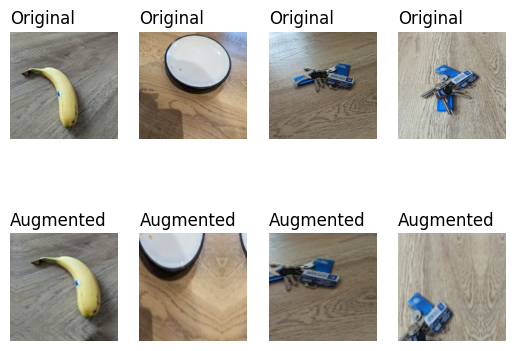

In [6]:
for images, labels in unlabeled_dataset.take(1):
  augmented_image = myaugmenter()(images)
  for i in range(1,5):
    plt.subplot(2,4,i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title("Original", loc="left")
  for i in range(1,5):
    plt.subplot(2,4,4+i)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title("Augmented", loc="left")
plt.show()

## 5. MICLe Model

A new class for MICLe is created using _keras.Model_ as the base. The loss function used is the _Contrastive Loss_ function shown in Eq. (1) which has been added as a function to MICLe [4]. Most modifications occur in the _compile_ and _train_step_ functions. An optimizer is added to the _compile_ function to be able to track the _Contrastive Loss_ while the _train_step_ function follows the algorithm shown in Section 2. A simple encoder function _f(.)_ and projection head _g(.)_ are used for demonstration purposes. These are customizable and can be changed according to the user.

In [7]:
class ContrastiveInstanceModel(keras.Model):
    def __init__(self): # initialize
        super().__init__()

        self.temperature = temperature
        self.encoder = myencoder(width, image_size, image_channels) # encoder network from encodeutil.py (Customizable)
        self.augmenter = myaugmenter() # augmenterfunction

        # Non-linear MLP as projection head (Customizable)
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )

    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer # Add optimizer

        self.contrastive_loss_tracker = keras.metrics.Mean(name="contrastive_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="contrastive_acc"
        )

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
        ]

    def contrastive_loss(self, z_i, z_j):

        # Cosine similarity: the dot product of the l2-normalized vectors
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        cos_sim = tf.math.exp(
            tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of images from the same bag
        # should be higher than their similarity with images from another bag
        batch_size = tf.shape(z_i)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, cos_sim)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(cos_sim)
        )

        # Using temperature scaled similarities for cross-entropy creates Contrastive Loss
        # the loss needs to symmetrized 
        loss_i_j = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, cos_sim, from_logits=False
        )
        loss_j_i = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(cos_sim), from_logits=False
        )
        return (loss_i_j + loss_j_i) / 2

    def train_step(self, data):
        (x, x_l), (y, y_l) = data # extract tensors from dataset
        t_i = self.augmenter(x, training=True) # augment tensors
        t_j = self.augmenter(y, training=True)
        with tf.GradientTape() as tape: # use GradientTape to create contrastive loss and optimize
            # The images are encoded
            features_1 = self.encoder(t_i, training=True)
            features_2 = self.encoder(t_j, training=True)
            # The representations are passed through the projection mlp
            z_i = self.projection_head(features_1, training=True)
            z_j = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(z_i, z_j)
        # Minimizing the Contrastive Loss
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        # Optimize
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)
 
        return {m.name: m.result() for m in self.metrics} # returns metrics for each epoch

Great! Now that we have our model we can fit it to a dataset. We have already created a dataset containing two tensors with each tensor having an image from each bag. So lets apply _train_data_ to our model.

In [8]:
# Contrastive pretraining
pretrain_MICLe_model = ContrastiveInstanceModel()
pretrain_MICLe_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(), # use Adam optimizer
    run_eagerly=True
)

MICLe_history = pretrain_MICLe_model.fit(  
    train_data, epochs=num_epochs, # fit to train_data
)

print(
    "Maximal Contrastive Accuracy: {:.2f}%".format(
        max(MICLe_history.history["contrastive_acc"]) # maximum contrastive accuracy across all epoch
    )
)

## Complete metric data can be seen by calling:
## print(pretraining_history.history)

Epoch 1/10
3/3 [==============================] - 14s 4s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.3000
Epoch 2/10
3/3 [==============================] - 11s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.3000
Epoch 3/10
3/3 [==============================] - 10s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.2333
Epoch 4/10
3/3 [==============================] - 9s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.2667
Epoch 5/10
3/3 [==============================] - 10s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.2000
Epoch 6/10
3/3 [==============================] - 10s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.1667
Epoch 7/10
3/3 [==============================] - 9s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.1333
Epoch 8/10
3/3 [==============================] - 9s 3s/step - contrastive_loss: 1.6094 - contrastive_acc: 0.1333
Epoch 9/10
3/3 [==============================] - 9s 3s/step - contrastive_loss: 1.

Now that our model is pretrained, we have a stronger representation for images when finetuned.

## 6. Finetuning

We can now conduct supervised finetuning. For this we require a labeled dataset.

### Dataset for Finetuning

The labeled dataset that we are going to use is an original dataset containing images of 4 clases : _orange, banana, tomato, apple_. Each class contains multiple images. We are going to finetune our MICLe model on this dataset of images of fuits. The dataset is split into a training set and a validation set. Let us import the dataset from our directory.

In [11]:
class_names = ['orange', 'banana', 'tomato', 'apple']

labeled_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/labeled_images', labels= 'inferred', label_mode= 'int', shuffle= True, 
    image_size=(image_size, image_size), batch_size= 2, seed = 2, validation_split = 0.3,
    subset = 'both'  
)

labeled_train , labeled_validate = labeled_dataset

Found 14 files belonging to 4 classes.
Using 10 files for training.
Using 4 files for validation.


To finetune our model we need to create a model which takes the pretrained model as a base on which it trains. For this tutorial we will be using a simple neural network, _finetuning_model_. However, this is easily customizable to implement more complex supervised training methods. After compiling, _finetuning_model_ is trained on _labeled_train_ and validated on _labeled_validate_, datasets we previously imported and created.

In [12]:
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        pretrain_MICLe_model.encoder, # the pretrained MICLe model weights are called 
        layers.Dense(20), # Here a simple Dense layer is added to conclude the model. 
        # To customize add layers from the previous line
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train, epochs=num_epochs, validation_data = labeled_validate # train and validate
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100 # maximum validation accuracy across all epochs
    )
)

Epoch 1/10
5/5 [==============================] - 12s 2s/step - loss: 15481.3027 - acc: 0.0000e+00 - val_loss: 8225.7559 - val_acc: 0.2500
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 4150.0005 - acc: 0.2000 - val_loss: 1952.1984 - val_acc: 0.2500
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 1677.2402 - acc: 0.1000 - val_loss: 439.1986 - val_acc: 0.2500
Epoch 4/10
5/5 [==============================] - 8s 2s/step - loss: 415.8019 - acc: 0.6000 - val_loss: 962.8555 - val_acc: 0.2500
Epoch 5/10
5/5 [==============================] - 7s 2s/step - loss: 244.2088 - acc: 0.6000 - val_loss: 332.3727 - val_acc: 0.5000
Epoch 6/10
5/5 [==============================] - 8s 2s/step - loss: 190.6244 - acc: 0.7000 - val_loss: 99.7559 - val_acc: 0.2500
Epoch 7/10
5/5 [==============================] - 8s 2s/step - loss: 6.3284 - acc: 0.9000 - val_loss: 335.4462 - val_acc: 0.2500
Epoch 8/10
5/5 [==============================] - 8s 2s/step - loss: 19.086

This finetuned model can now be be used predict classes for other datasets with the same classes. Since the model was built on a base of _keras.Model_ most methods and attributes of tf.keras.Model can be utilized. Methods such as _tf.keras.Model.predict()_, _tf.keras.Model.evaluate()_ can be very useful for future use. The model can also be further trained, however it might be easier to altogether create a different finetuning model and train. 

## 7. Contemporary Work & Limitations

While MICLe has been shown to be extremely promising, the rise of self-supervision methods has brought a few competitors. MICLe itself is based on SIMCLR, a contrastive learning based model which creates positive pairs by applying two random augmentations to the same image, based on which contrastive loss is calculated [2]. The contrastive loss function used in MICLe is the same as SIMCLR however depending on the dataset one model might be more advantageous than the other. MICLe is majorly restricted by its requirements of multiple images in one bag, where the bag describes a single object. While this proves useful for the appropriate dataset, SIMCLR perhaps would perform better on datasets without multiple instances as it can stil create a positive pair through augmentation. However as in _Azizi et al._ [1], they complement each other and so pretraining twice, once with each model, seems to be the way to go when the dataset allows it. 

The success of contrastive learning in self-supervised methods has also prompted its use in fully supervised settings, such as with SupCon. SupCon is the supervised learning analogue to the Contrastive Loss seen in MICLe and SIMCLR [3].

Although there has already been great progress made, there are a few exciting avenues still left to explore. We still don't know the limit of self-supervised, contrastive learning based pretraining, on huge unlabeled datasets. Another consideration is that as of now the self-supervised models are pretrained on a combination of task specific and generic datasets. So, it would also be interesting to see how well a model pretrained on a task specific datasets could generalize to other tasks. The reach of Self-supervision methods is still undetermined and more research could lead to great developements in the future. 

# Bibliography

1. S. Azizi _et al., Big Self-Supervised Models Advance Medical Image Classification._ 2021. doi: 10.1109/iccv48922.2021.00346.
2. T. Chen, S. Kornblith, M. Norouzi, and G. E. Hinton, A Simple Framework for Contrastive Learning of Visual Representations, vol. 1. 2020, pp. 1597–1607. [Online]. Available: http://proceedings.mlr.press/v119/chen20j/chen20j.pdf
3. P. Khosla et al., Supervised Contrastive Learning, vol. 33. 2020, pp. 18661–18673. [Online]. Available: https://proceedings.neurips.cc/paper/2020/file/d89a66c7c80a29b1bdbab0f2a1a94af8-Paper.pdf
4. K. Team, “Keras documentation: Semi-supervised image classification using contrastive pretraining with SimCLR.” https://keras.io/examples/vision/semisupervised_simclr/